This notebook allows to reproduce Figures 1, 2 and 3 from Pessi *et al.*, 2024, *ELEPHANT: ExtragaLactic alErt Pipeline for Hostless AstroNomical Transients*

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib
from astropy.visualization import simple_norm

In [6]:
colors={"orange":"#ED9145",
        "dark_brown":"#473832",
        "beige":"#E2D3C1",
        "rose":"#BC7E74",
        "dark_blue":"#21609D",
        "light_blue":"#5C92C1",
        "dark_gray":"#4D5966",
        "black":"#27242A",
        "light_gray":"#8999A1",
        "golden_brown":"#87581D"}

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [colors['dark_blue'],
                                                                colors['orange']])

# Figure 1

In [7]:
obj_data_host = pd.read_parquet('../data/ZTF23aaptfsu.parquet')

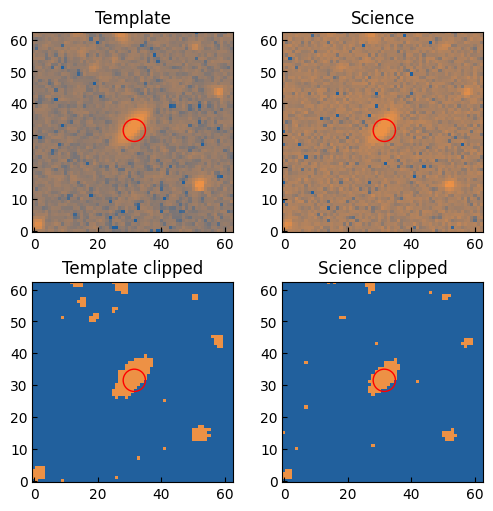

In [8]:
#Host example: https://fink-portal.org/ZTF23aaptfsu
fig,ax=plt.subplots(2,2,figsize=(5,5),layout='constrained')

circle1 = plt.Circle((31.5,31.5), 3.5, color='r', fill=False)
circle2 = plt.Circle((31.5,31.5), 3.5, color='r', fill=False)
circle3 = plt.Circle((31.5,31.5), 3.5, color='r', fill=False)
circle4 = plt.Circle((31.5,31.5), 3.5, color='r', fill=False)

#Not clipped
image_data0 = np.frombuffer(obj_data_host['b:cutoutTemplate_stampData_stacked'].values[0], 
                            dtype="float32").reshape(63, 63)
image_data1 = np.frombuffer(obj_data_host['b:cutoutScience_stampData_stacked'].values[0], 
                                    dtype="float32").reshape(63, 63)
norm0 = simple_norm(image_data0, 'log', percent=99.)
norm1 = simple_norm(image_data1, 'log', percent=99.)

#Clipped
#print(monster_df['template_clipped'][i])
image_data2 = np.frombuffer(obj_data_host['template_clipped'].values[0], 
                            dtype="float64").reshape(63, 63)
image_data3 = np.frombuffer(obj_data_host['science_clipped'].values[0], 
                            dtype="float64").reshape(63, 63)
norm2 = simple_norm(image_data2, 'log', percent=99.)
norm3 = simple_norm(image_data3, 'log', percent=99.)
                
ax[0][0].imshow(image_data0,norm=norm0, origin='lower',interpolation='nearest',
                       cmap=cmap)
ax[0][1].imshow(image_data1,norm=norm1, origin='lower',interpolation='nearest',
                      cmap=cmap)
ax[0][0].set_title('Template')
ax[0][1].set_title('Science')

ax[1][0].imshow(image_data2,norm=norm2, origin='lower', interpolation='nearest',
                      cmap=cmap)
ax[1][1].imshow(image_data3,norm=norm3, origin='lower', interpolation='nearest',
                       cmap=cmap)
ax[1][0].set_title('Template clipped')
ax[1][1].set_title('Science clipped')

ax[0][0].add_patch(circle1)
ax[0][1].add_patch(circle2)
ax[1][0].add_patch(circle3)
ax[1][1].add_patch(circle4)

ax[0][0].tick_params(axis='both',direction='in')
ax[0][1].tick_params(axis='both',direction='in')
ax[1][0].tick_params(axis='both',direction='in')
ax[1][1].tick_params(axis='both',direction='in')
#plt.savefig('EG_success_host.pdf')
plt.show()
            

# Figure 2

In [9]:
obj_data_hostless = pd.read_parquet('../data/ZTF23abbsfxp.parquet')

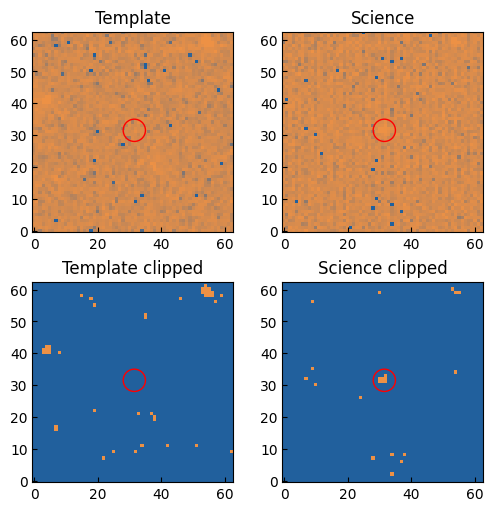

In [10]:
#No host example: https://fink-portal.org/ZTF23abbsfxp
fig,ax=plt.subplots(2,2,figsize=(5,5),layout='constrained')

circle1 = plt.Circle((31.5,31.5), 3.5, color='r', fill=False)
circle2 = plt.Circle((31.5,31.5), 3.5, color='r', fill=False)
circle3 = plt.Circle((31.5,31.5), 3.5, color='r', fill=False)
circle4 = plt.Circle((31.5,31.5), 3.5, color='r', fill=False)

#Not clipped
image_data0 = np.frombuffer(obj_data_hostless['b:cutoutTemplate_stampData_stacked'].values[0], 
                            dtype="float32").reshape(63, 63)
image_data1 = np.frombuffer(obj_data_hostless['b:cutoutScience_stampData_stacked'].values[0], 
                            dtype="float32").reshape(63, 63)
norm0 = simple_norm(image_data0, 'log', percent=99.)
norm1 = simple_norm(image_data1, 'log', percent=99.)

#Clipped
image_data2 = np.frombuffer(obj_data_hostless['template_clipped'].values[0], 
                            dtype="float64").reshape(63, 63)
image_data3 = np.frombuffer(obj_data_hostless['science_clipped'].values[0], 
                            dtype="float64").reshape(63, 63)
norm2 = simple_norm(image_data2, 'log', percent=99.)
norm3 = simple_norm(image_data3, 'log', percent=99.)
                
ax[0][0].imshow(image_data0,norm=norm0, origin='lower',interpolation='nearest',
                      cmap=cmap)
ax[0][1].imshow(image_data1,norm=norm1, origin='lower',interpolation='nearest',
                       cmap=cmap)
ax[0][0].set_title('Template')
ax[0][1].set_title('Science')

ax[1][0].imshow(image_data2,norm=norm2, origin='lower', interpolation='nearest',
                       cmap=cmap)
ax[1][1].imshow(image_data3,norm=norm3, origin='lower', interpolation='nearest',
                       cmap=cmap)
ax[1][0].set_title('Template clipped')
ax[1][1].set_title('Science clipped')
ax[0][0].add_patch(circle1)
ax[0][1].add_patch(circle2)
ax[1][0].add_patch(circle3)
ax[1][1].add_patch(circle4)

ax[0][0].tick_params(axis='both',direction='in')
ax[0][1].tick_params(axis='both',direction='in')
ax[1][0].tick_params(axis='both',direction='in')
ax[1][1].tick_params(axis='both',direction='in')
#plt.savefig('EG_success_no_host.pdf')
plt.show()

# Figure 3

In [13]:
obj_data_bug = pd.read_parquet('../data/ZTF22abbausm.parquet')

/media/emille/git/COIN/CRP7/hostless/venv/alerce/lib/python3.8/site-packages/astropy/visualization/mpl_normalize.py:180: RuntimeWarning: invalid value encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)


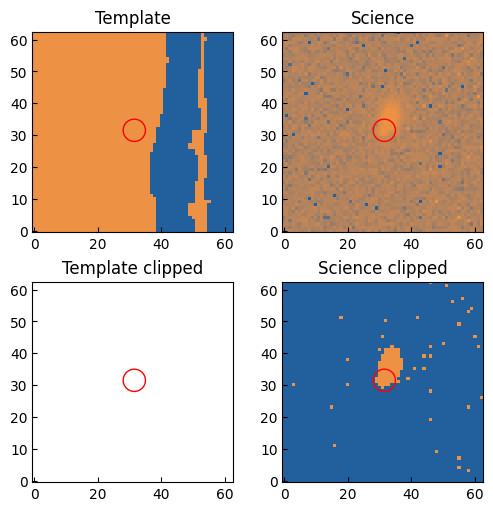

In [15]:
#No host bad detection example: https://fink-portal.org/ZTF22abbausm
fig,ax=plt.subplots(2,2,figsize=(5,5),layout='constrained')

circle1 = plt.Circle((31.5,31.5), 3.5, color='r', fill=False)
circle2 = plt.Circle((31.5,31.5), 3.5, color='r', fill=False)
circle3 = plt.Circle((31.5,31.5), 3.5, color='r', fill=False)
circle4 = plt.Circle((31.5,31.5), 3.5, color='r', fill=False)


#Not clipped
image_data0 = np.frombuffer(obj_data_bug['b:cutoutTemplate_stampData_stacked'].values[0], 
                            dtype="float32").reshape(63, 63)
image_data1 = np.frombuffer(obj_data_bug['b:cutoutScience_stampData_stacked'].values[0], 
                            dtype="float32").reshape(63, 63)
norm0 = simple_norm(image_data0, 'log', percent=99.)
norm1 = simple_norm(image_data1, 'log', percent=99.)

#Clipped
#print(monster_df['template_clipped'][i])
image_data2 = np.frombuffer(obj_data_bug['template_clipped'].values[0], 
                            dtype="float64").reshape(63, 63)
image_data3 = np.frombuffer(obj_data_bug['science_clipped'].values[0], 
                            dtype="float64").reshape(63, 63)
norm2 = simple_norm(image_data2, 'log', percent=99.)
norm3 = simple_norm(image_data3, 'log', percent=99.)
                
ax[0][0].imshow(image_data0,norm=norm0, origin='lower',interpolation='nearest',
                       cmap=cmap)
ax[0][1].imshow(image_data1,norm=norm1, origin='lower',interpolation='nearest',
                       cmap=cmap)
ax[0][0].set_title('Template')
ax[0][1].set_title('Science')

ax[1][0].imshow(image_data2,norm=norm2, origin='lower', interpolation='nearest',
                       cmap=cmap)
ax[1][1].imshow(image_data3,norm=norm3, origin='lower', interpolation='nearest',
                       cmap=cmap)
ax[1][0].set_title('Template clipped')
ax[1][1].set_title('Science clipped')

ax[0][0].add_patch(circle1)
ax[0][1].add_patch(circle2)
ax[1][0].add_patch(circle3)
ax[1][1].add_patch(circle4)

ax[0][0].tick_params(axis='both',direction='in')
ax[0][1].tick_params(axis='both',direction='in')
ax[1][0].tick_params(axis='both',direction='in')
ax[1][1].tick_params(axis='both',direction='in')
#plt.savefig('EG_fail.pdf')
plt.show()